# Gradient boosting

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":10,"axes.titlesize":24,"axes.labelsize":24}) 
from sklearn import tree
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.metrics import mean_squared_error,r2_score

## Load data

In [2]:
X_train_complete = pd.read_csv("TrainNormalized.csv")
X_test = pd.read_csv("TestNormalized.csv")
#X_PCA = pd.read_csv("TrainClean10PCA.csv")
#X_train_complete.describe()

In [3]:
#X_train_complete.columns

## Regression on NumberOfCustomers

In [4]:
y=X_train_complete['NumberOfCustomers'].values.reshape(-1,1)
x=X_train_complete.drop(columns=[X_train_complete.columns[0],'NumberOfCustomers','NumberOfSales'],axis=1)

## Lasso feature selection

In [11]:
lasso = linear_model.LassoCV(cv=10)
lasso_fit=lasso.fit(x,y)
yp_lasso = lasso.predict(x)
r2_simple_train = r2_score(y,yp_lasso)
rmse_simple_train = mean_squared_error(y,yp_lasso,multioutput='raw_values')
print("Linear Regression with Lasso")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\nLinear Regression with Lasso - Parameters")
selected=[]
for i,c in enumerate(np.append(lasso_fit.intercept_,lasso_fit.coef_)):
    if c>0:
        selected.append(x.columns[i])
    #print("%d\t%3.3f" % (i,c) )

Linear Regression with Lasso
	                  Train R2=0.322
	                  Train RMSE=16958.834

Linear Regression with Lasso - Parameters
0	355.858
1	-0.000
2	64.212
3	-106.837
4	-51.326
5	0.000
6	-0.000
7	-4.065
8	-1.812
9	-1.745
10	-22.782
11	-33.050
12	7.160
13	0.000
14	-0.000
15	0.000
16	0.000
17	-0.000
18	-3.004
19	0.000
20	0.000
21	-8.995
22	40.212
23	-0.000
24	9.529
25	-21.055
26	-66.891
27	-11.911
28	0.000
29	291.690
30	-25.827
31	389.820
32	-0.000
33	4.089
34	-23.619
35	-0.000
36	47.315
37	88.518
38	-19.575
39	-33.559
40	-29.359
41	-63.018
42	5.527
43	-12.131
44	-10.601
45	-3.655
46	2.274
47	9.762
48	4.604
49	0.000
50	-0.000
51	-6.366
52	-4.640
53	0.289
54	49.457
55	0.180
56	-1.085
57	0.000
58	0.989
59	-6.158
60	0.112
61	-0.117
62	-0.075
63	-1.948
64	0.889
65	0.446
66	-0.000
67	1.897
68	-1.905


In [31]:
selected=[]
for i,c in enumerate(np.append(lasso_fit.intercept_,lasso_fit.coef_)):
    if c>0:
        selected.append(x.columns[i])
x=x[selected]

In [35]:
x.columns

Index(['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Region_GDP', 'Region_PopulationK', 'CloudCover', 'Max_Dew_PointC',
       'Max_Humidity', 'Max_Sea_Level_PressurehPa', 'Max_TemperatureC',
       'Max_VisibilityKm', 'Max_Wind_SpeedKm_h', 'Mean_Dew_PointC',
       'Mean_Humidity', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC',
       'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC',
       'Min_Humidity', 'Min_Sea_Level_PressurehPa', 'Min_TemperatureC',
       'Min_VisibilitykM', 'Precipitationmm', 'StandardMarket', 'HyperMarket',
       'SuperMarket', 'ShoppingCenter', 'General', 'WithFishDepartment',
       'WithNonFoodDepartment', 'Region0', 'Region1', 'Region2', 'Region3',
       'Region4', 'Region5', 'Region6', 'Region7', 'Region8', 'Region9',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'Rain', 'Fog',
       'Hail', 'Nothing', 'Snow', 'Thunde

## Try different model complexities

In [33]:
perf=[]
cross_tot=[]
n=12
for i in np.arange(n)+1:
    
    clf = tree.DecisionTreeRegressor(max_depth=i)
    
    #clf = linear_model.LinearRegression()
    #poly=PolynomialFeatures(x)
    #poly.fit_transform(x)
    
    #clf=neighbors.KNeighborsRegressor(i)
    
    clf = clf.fit(x, y)
    #clf = clf.fit(xp, y)
    yp = clf.predict(x).reshape(-1,1)
    #yp = clf.predict(xp).reshape(-1,1)
    
    cross=cross_val_score(clf,x,y).mean() # This is a 3 folds cross-val. As the dataset is big, it's enough!
    #cross=cross_val_score(clf,xp,y).mean()
    cross_tot.append(cross)
    perf.append((i,mean_squared_error(y,yp),r2_score(y,yp),cross))
print("Complexity , RMSE , R2 , crossval_score")
perf

Complexity , RMSE , R2 , crossval_score


[(1, 21459.044300149246, 0.14155738044153643, 0.033292279518822),
 (2, 18379.00021871257, 0.264770747851643, 0.126607503642763),
 (3, 16466.648484948204, 0.34127202204112006, 0.037541217841922665),
 (4, 14939.593369403545, 0.40235997988597105, 0.17373312500055538),
 (5, 13936.85129164833, 0.44247344085513907, 0.18892459998159974),
 (6, 13122.901939952013, 0.4750344815000499, 0.0855893461802879),
 (7, 12243.774878454202, 0.5102028760958738, 0.19502006613052422),
 (8, 11294.579326983165, 0.5481742742756319, -0.02753398168763906),
 (9, 10272.006532164116, 0.5890810386401372, 0.07066172721981472),
 (10, 9380.131834309108, 0.6247593867173273, 0.007715095027581387),
 (11, 8368.329123493355, 0.6652353071451065, -0.17961900228948657),
 (12, 7226.6087975527635, 0.7109084216461454, -0.042365912603266574)]

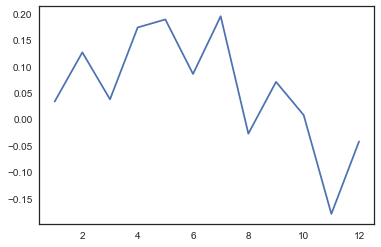

In [34]:
plt.plot(list(np.arange(n)+1),cross_tot,)

## Gradient Boosting

Step 1 generating the first model

In [5]:
perf=[]
model_list=[] # lol
prediction = np.zeros((len(y),1))
clf = tree.DecisionTreeRegressor(max_depth=1)
#clf = linear_model.LinearRegression()
#clf=neighbors.KNeighborsRegressor(2)
clf = clf.fit(x, y)
model_list.append(clf)
yp = clf.predict(x).reshape(-1,1)
prediction += yp
y_residual = y-yp
perf.append((mean_squared_error(y,prediction),r2_score(y,prediction)))

Step 2 loop generating models to describe residuals of the previous models

In [6]:
no_boosting_runs = 100
for i in range(no_boosting_runs):
    clf = tree.DecisionTreeRegressor(max_depth=1)
    #clf = linear_model.LinearRegression()
    # suggested no_boosting_runs = 3 for KNN
    #clf=neighbors.KNeighborsRegressor(2)
    clf = clf.fit(x, y_residual)
    model_list.append(clf)
    yp = clf.predict(x).reshape(-1,1)
    # update the prediction
    prediction += yp
    y_residual = y-prediction
    perf.append((mean_squared_error(y,prediction),r2_score(y,prediction)))

In [7]:
print("RMSE , R2")
perf[-20:]

RMSE , R2


[(142.97280237373116, 0.9942805492509996),
 (140.6786196097808, 0.9943723252049557),
 (138.84653663141896, 0.9944456154265143),
 (136.60729421188438, 0.9945351935597044),
 (134.84093760641215, 0.9946058544787215),
 (132.93768274900236, 0.994681991843584),
 (131.0059332476558, 0.9947592691015584),
 (129.43903077770486, 0.9948219511037055),
 (127.67209274552441, 0.9948926352819815),
 (125.82708357264791, 0.9949664426000204),
 (124.34213970629371, 0.9950258459492424),
 (122.76849385419376, 0.9950887977120814),
 (121.18947650547749, 0.9951519643550222),
 (119.73841204436103, 0.995210012400393),
 (118.3844453456086, 0.9952641761694507),
 (116.94281874229989, 0.9953218466649518),
 (115.30599411744551, 0.9953873258167287),
 (113.67087753232315, 0.9954527366404813),
 (112.51968594871911, 0.9954987886409721),
 (111.35044036300076, 0.9955455628695664)]

Define a function to perform model evaluation

In [8]:
def GradientBoosting_eval(models,x):
    prediction = np.zeros((len(x),1))
    for model in models:
        yp = model.predict(x).reshape(-1,1)
        prediction += yp
    return prediction.reshape(-1,1)

result=GradientBoosting_eval(model_list,x)

In [9]:
result

array([[495.6416648 ],
       [623.81216232],
       [656.12823231],
       ...,
       [264.0067668 ],
       [354.13636157],
       [305.76874346]])

In [25]:
model_list

[DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=1,